In [1]:
import pandas as pd
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
import skbio.stats.composition
import threadpoolctl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import umap
import time
import numba
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

import networkx as nx
import graph_tool as gt

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(figsize=(12, 12))
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


@numba.njit()
def rho(a, b):
    covariance_mat = np.cov(a, b, rowvar=True)
    covariance = covariance_mat[0, 1]
    var_a = covariance_mat[0, 0]
    var_b = covariance_mat[1, 1]
    vlr = -2 * covariance + var_a + var_b
    rho = 1 - vlr / (var_a + var_b)
    rho += 1
    rho = 2 - rho

    return rho


# Two Strains

In [2]:
#Two Strains

# rho = pd.read_csv('rho_matrix.tsv', sep='\t')
two_depths_df = pd.read_csv('two_test_depths.vcf', sep="\t")
two_depths_raw = two_depths_df.values
# if correct labelled
two_depths_raw = two_depths_df.iloc[:,:-1].values
# depths = scale(depths, axis=0, with_mean=True, with_std=True, copy=True)
two_depths_clr = skbio.stats.composition.clr(two_depths_raw+1)
two_depths = MinMaxScaler().fit_transform(two_depths_raw)

var_d = pd.read_csv('var_depths.vcf', sep="\t") + 1
ref_d = pd.read_csv('ref_depths.vcf', sep="\t") + 1
# depths_clr = skbio.stats.composition.clr(var_d)
two_depths_pca = PCA(n_components=2, svd_solver='full')
two_depths_pca.fit(two_depths_raw.T)
# projection = TSNE().fit_transform(depths)

PCA(n_components=2, svd_solver='full')

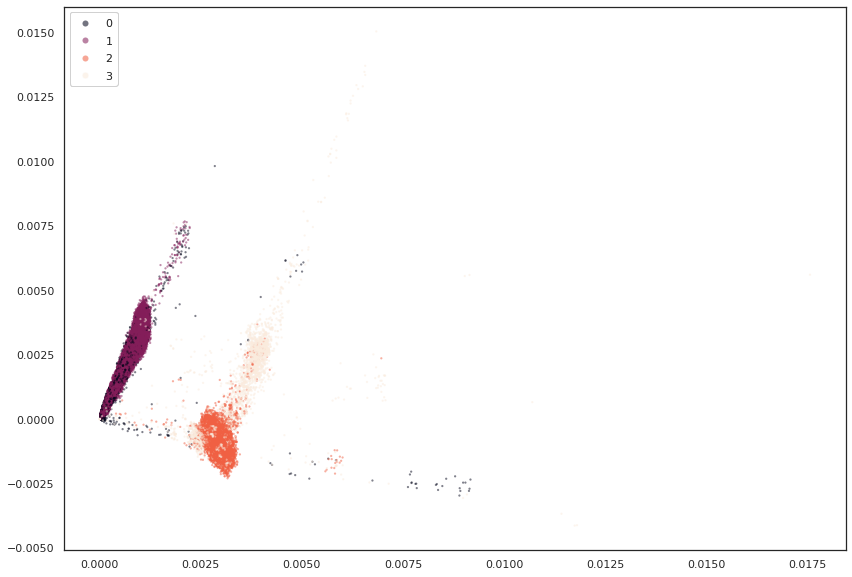

In [290]:
## Correctly labelled
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    *two_depths_pca.components_[0:2], 
#     two_embedding[:, 2],
    s=5, linewidth=0, c=two_depths_df.iloc[:,-1].values, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)

In [5]:
### UMAP
tic = time.clock()
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
#     spread=3,
    n_components=2,
)
two_embedding = reducer.fit_transform(two_depths_clr)
two_embedding.shape
toc = time.clock()
print((toc - tic)/60)

51.12217313333333


Text(0.5, 1.0, 'UMAP projection')

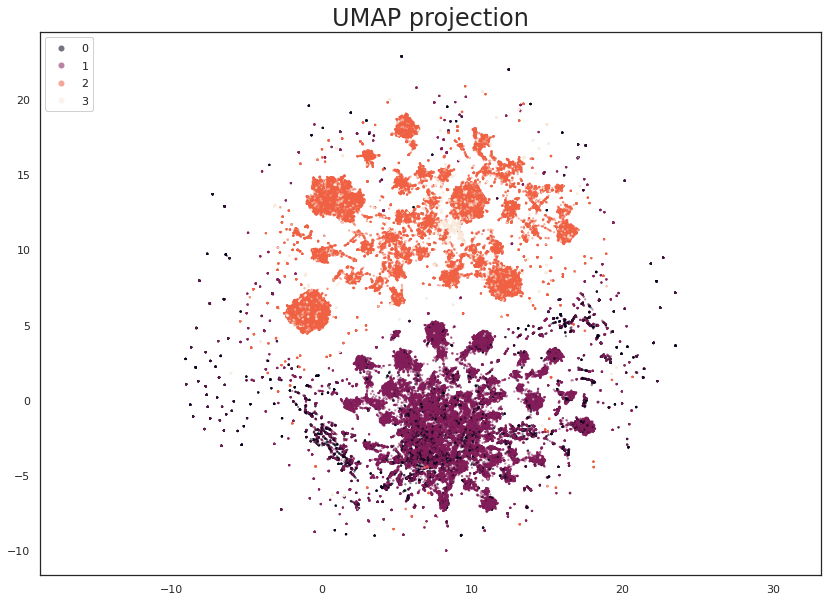

In [8]:
## PLot correctly labelled UMAP
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    two_embedding[:, 0],
    two_embedding[:, 1], 
#     two_embedding[:, 2],
    s=5, linewidth=0, c=two_depths_df.iloc[:,-1].values, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [9]:
## UMAP Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(two_depths.shape[0]*0.01), min_samples=1, prediction_data=True, cluster_selection_method="eom")
clusterer.fit(two_embedding)

## PCA Clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=100, prediction_data=True, cluster_selection_method="eom")
# clusterer.fit(two_depths_pca.components_.T)

HDBSCAN(min_cluster_size=2121, min_samples=1, prediction_data=True)

0 found 5129 and soft labels 5139
1 found 15960 and soft labels 15985
2 found 2293 and soft labels 2687
3 found 2531 and soft labels 2560
4 found 5201 and soft labels 4547
5 found 5269 and soft labels 5569
6 found 5966 and soft labels 5915
7 found 15412 and soft labels 14632
8 found 2183 and soft labels 2509
9 found 2234 and soft labels 3906
10 found 16452 and soft labels 15092
11 found 3868 and soft labels 3874
12 found 3458 and soft labels 4528
13 found 2214 and soft labels 5150
14 found 16968 and soft labels 14851
15 found 6332 and soft labels 6232
16 found 4549 and soft labels 3405
17 found 3615 and soft labels 4874
18 found 7930 and soft labels 5538
19 found 6737 and soft labels 6625
20 found 5938 and soft labels 5722
21 found 5522 and soft labels 5074
22 found 3769 and soft labels 4262
23 found 2262 and soft labels 3592
24 found 3814 and soft labels 3777
25 found 3083 and soft labels 3905
26 found 28835 and soft labels 30013
27 found 4364 and soft labels 4241
28 found 5287 and so

<AxesSubplot:ylabel='$\\lambda$ value'>

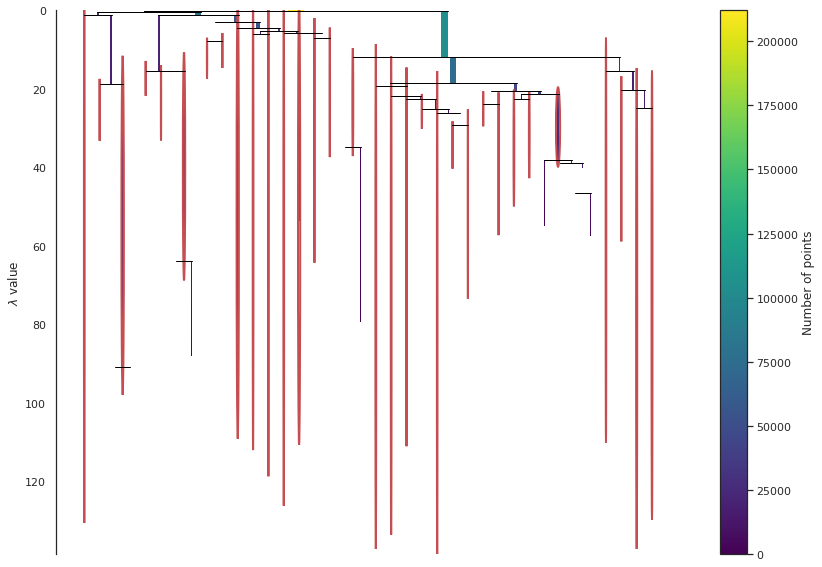

In [294]:
labels = set(clusterer.labels_)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_clusters = [np.argmax(x) for x in soft_clusters]

# print(soft_clusters)
for label in labels: 
    print("%d found %d and soft labels %d" % (label, np.count_nonzero(clusterer.labels_ == label), np.count_nonzero(soft_clusters == label)))
    
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
# plt.savefig("test.png")

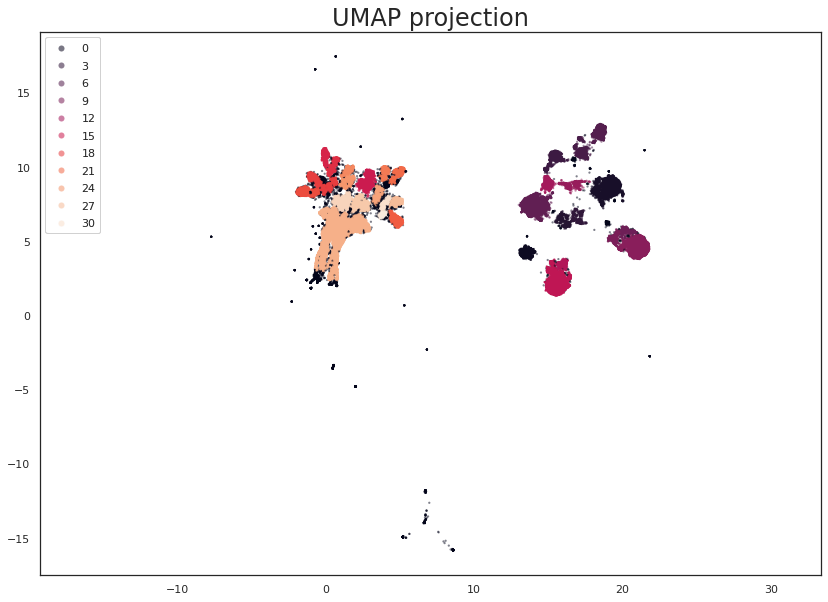

In [297]:
color_palette = sns.color_palette('Paired', 200)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in soft_clusters]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
scatter = ax.scatter(
    two_embedding[:, 0],
    two_embedding[:, 1], 
    s=5, linewidth=0, c=clusterer.labels_, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)


# plt.scatter(
#     *two_depths_pca.components_[0:2],
#     s=5, linewidth=0, c=soft_clusters, alpha=0.5
# )

# Three Strains

In [4]:

# rho = pd.read_csv('rho_matrix.tsv', sep='\t')
three_depths_df = pd.read_csv('three_test_depths.vcf', sep="\t")
three_depths_raw = three_depths_df.iloc[:,:-1].values
# three_depths_clr = skbio.stats.composition.clr((three_depths_raw + 1))
three_depths_clr = skbio.stats.composition.clr((three_depths_raw + 1).T).T

# depths = scale(depths, axis=0, with_mean=True, with_std=True, copy=True)
three_depths = MinMaxScaler().fit_transform(three_depths_raw)

var_d = pd.read_csv('three_var_depths.vcf', sep="\t") + 1
ref_d = pd.read_csv('three_ref_depths.vcf', sep="\t") + 1
# depths_clr = skbio.stats.composition.clr(var_d)

# projection = TSNE().fit_transform(depths)
three_depths_df.values.shape


(16284, 11)

Text(0.5, 1.0, 'PCA labelled by variant assignment')

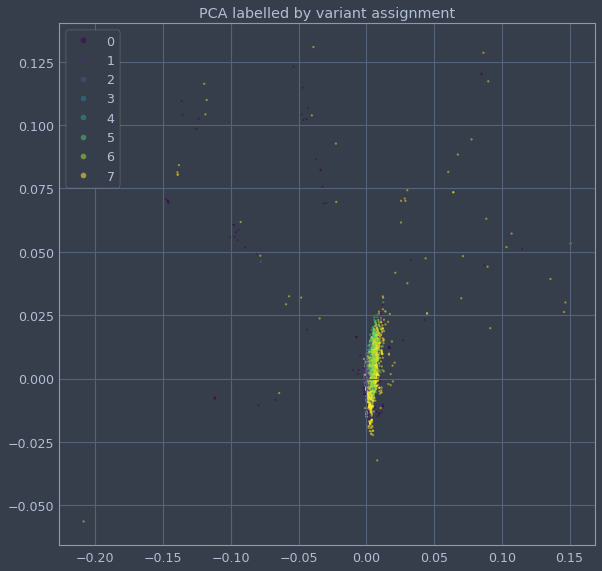

In [40]:
## Correctly labelled
three_depths_pca = PCA(n_components=2, svd_solver='full')
three_depths_pca.fit(three_depths.T)
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    *three_depths_pca.components_[0:2], 
#     two_embedding[:, 2],
    s=5, linewidth=0, c=three_depths_df.iloc[:,-1].values, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
plt.title("PCA labelled by variant assignment")

In [5]:
### UMAP
tic = time.clock()
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
#     spread=0,
    n_components=2,
    random_state=42,
    metric=rho
)
three_embedding = reducer.fit_transform(three_depths_clr)
three_embedding.shape
toc = time.clock()
print((toc - tic)/60)

/home/n10853499/.conda/envs/r-3.6.3/lib/python3.6/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


2.2575678666666668


In [1]:
## PLot correctly labelled UMAP
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    three_embedding[:, 0],
    three_embedding[:, 1], 
#     three_embedding[:, 2],
    s=5, linewidth=0, 
    c=three_depths_df.iloc[:,-1].values,
#     c="black",
    alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

NameError: name 'plt' is not defined

In [7]:
## UMAP Clustering

three_tuned = hyperparameter_selection(three_embedding, cores=100)
three_best = best_validity(three_tuned)
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                            approx_min_span_tree=True,
                            gen_min_span_tree=True,
                            leaf_size=40,
                            cluster_selection_method='eom',
                            metric='euclidean', 
                            min_cluster_size=int(three_best['min_cluster_size']), 
                            min_samples=int(three_best['min_samples']), 
                            allow_single_cluster=False,
                            core_dist_n_jobs=20,
                            prediction_data=True)
clusterer.fit(three_embedding)

## PCA Clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=100, prediction_data=True, cluster_selection_method="eom")
# clusterer.fit(three_depths_pca.components_.T)

min_cluster_size = 127,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.6089260043925299 n_clusters = 14
min_cluster_size = 127,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.5248550477277619 n_clusters = 13
min_cluster_size = 127,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.5700147300914752 n_clusters = 13
min_cluster_size = 127,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.5303551708752302 n_clusters = 13
min_cluster_size = 127,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.6515589878901366 n_clusters = 13
min_cluster_size = 255,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.6468175459084787 n_clusters = 7
min_cluster_size = 382,  min_samples = (127, 2, 0.21478632670830183, 16), validity_score = 0.6293912602330679 n_clusters = 6


HDBSCAN(core_dist_n_jobs=20, gen_min_span_tree=True, min_cluster_size=127,
        min_samples=18, prediction_data=True)

Process ForkPoolWorker-79:
Process ForkPoolWorker-73:
Process ForkPoolWorker-55:
Process ForkPoolWorker-87:
Process ForkPoolWorker-97:
Process ForkPoolWorker-93:
Process ForkPoolWorker-53:
Process ForkPoolWorker-70:
Process ForkPoolWorker-75:
Process ForkPoolWorker-60:
Process ForkPoolWorker-14:
Process ForkPoolWorker-41:
Process ForkPoolWorker-37:
Process ForkPoolWorker-88:
Process ForkPoolWorker-94:
Process ForkPoolWorker-38:
Process ForkPoolWorker-81:
Process ForkPoolWorker-42:
Process ForkPoolWorker-52:
Process ForkPoolWorker-39:
Process ForkPoolWorker-43:
Process ForkPoolWorker-57:
Process ForkPoolWorker-12:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-85:
Process ForkPoolWorker-5:
Process ForkPoolWorker-89:
Process ForkPoolWorker-15:
Process ForkPoolWorker-58:
Process ForkPoolWorker-91:
Process ForkPoolWorker-95:
Process ForkPoolWorker-76:
Process ForkPoolWorker-20:
Process ForkPoolWorker-82:
Process ForkPoolWorker-29:
Process ForkPoolWorker-96:
Proc

In [8]:
import multiprocessing as mp
import itertools
import numba
import threadpoolctl

numba.set_num_threads(100)

def cluster_distances(embeddings, cluster_result, threads):
    with threadpoolctl.threadpool_limits(limits=1, user_api='blas'):
        pool = mp.Pool(threads)
        labels = set(cluster_result.labels_)

        dist_mat = np.zeros((len(labels), len(labels)))

        dist_results = [pool.apply_async(get_dist, args=(first, second, embeddings, cluster_result)) for (first, second) in itertools.combinations(labels, 2)]

        for result in dist_results:
            result = result.get()
            dist_mat[result[0], result[1]] = result[2]
            dist_mat[result[1], result[0]] = result[2]
        pool.close()
        pool.join()

        return dist_mat

# hdbscan.validity.validity_index(X=three_embedding.astype(np.float64), labels=clusterer.labels_, per_cluster_scores=True)
# hdbscan.plots.MinimumSpanningTree(clusterer.minimum_spanning_tree_, three_embedding).plot()

def get_dist(first, second, embeddings, cluster_result):
    
    (first_mr, first_core) = hdbscan.validity.all_points_mutual_reachability(embeddings, cluster_result.labels_, first)
    (first_nodes, first_edges) = hdbscan.validity.internal_minimum_spanning_tree(first_mr.astype(np.float64))
    (second_mr, second_core) = hdbscan.validity.all_points_mutual_reachability(embeddings, cluster_result.labels_, second)
    (second_nodes, second_edges) = hdbscan.validity.internal_minimum_spanning_tree(second_mr.astype(np.float64))
    
    sep = hdbscan.validity.density_separation(embeddings, cluster_result.labels_, first, second, first_nodes, second_nodes, first_core, second_core)
    
    return (first, second, sep)

In [19]:

dist_mat = cluster_distances(three_embedding, clusterer, 20)

KeyboardInterrupt: 

In [10]:
dist_mat

array([[0.        , 3.84115988, 4.7418451 , 3.5020454 , 0.88450334,
        1.45377694, 1.90317894, 3.79358015, 4.2360465 , 2.83374885,
        1.06857795, 3.34967952, 1.90433366, 3.54017811, 0.53824228],
       [3.84115988, 0.        , 7.76337796, 0.8750816 , 2.79083827,
        0.5378649 , 1.60187038, 7.39536746, 4.56509164, 3.11397219,
        5.64470339, 7.75876154, 5.16542697, 7.38154851, 0.69779565],
       [4.7418451 , 7.76337796, 0.        , 5.86656465, 3.92541701,
        6.568026  , 5.62640588, 0.60093004, 0.61574   , 3.0345599 ,
        2.58100263, 1.94795945, 1.09557584, 1.114378  , 0.77922488],
       [3.5020454 , 0.8750816 , 5.86656465, 0.        , 2.17732622,
        1.80013452, 0.80682366, 5.47648431, 3.18230789, 1.29216754,
        4.31396668, 6.04993599, 3.20909012, 5.50455134, 0.26711812],
       [0.88450334, 2.79083827, 3.92541701, 2.17732622, 0.        ,
        0.75886643, 0.65937481, 3.19132641, 2.95422701, 1.1881315 ,
        1.52501973, 3.39942793, 1.25134744, 

-0.1833948069020865


<AxesSubplot:ylabel='$\\lambda$ value'>

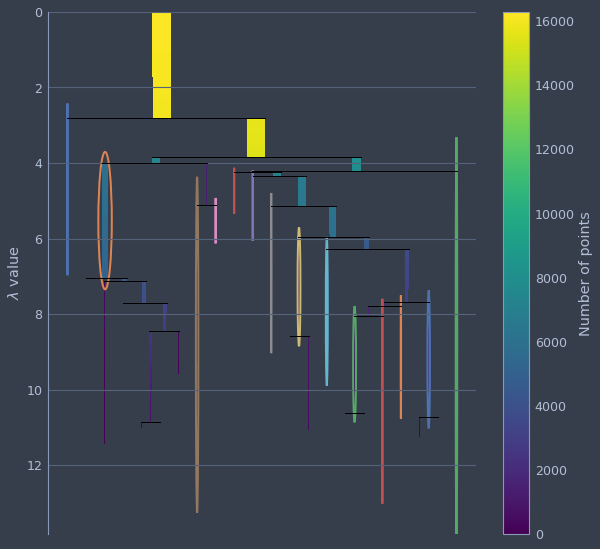

In [12]:
labels = set(clusterer.labels_)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_clusters = [np.argmax(x) for x in soft_clusters]

validity = hdbscan.validity.validity_index(three_embedding.astype(np.float64), clusterer.labels_)
print(validity)

# # print(soft_clusters)
# for label in labels: 
#     print("%d found %d and soft labels %d" % (label, np.count_nonzero(clusterer.labels_ == label), np.count_nonzero(soft_clusters == label)))
    
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 20))

In [30]:
from graph_tool.all import *
import matplotlib

df = clusterer.condensed_tree_.to_pandas()
# g = Graph(directed=False)
# g.add_edge_list(df.values)
# pos = graph_tool.draw.sfdp_layout(g)
# graph_draw(g, pos, vertex_color=[1,1,1,1,0], vertex_size=1, edge_pen_width=1.2, vcmap=matplotlib.cm.gist_heat_r, output_size=(1920, 1080))
# networkx.write_graphml(network, "three_strain_network.xml")

In [37]:
# print(int(three_depths.shape[0]*0.01))
df[df.child > three_depths.shape[0]]

,parent,child,lambda_val,child_size
194,16284,16285,1.115134,261
195,16284,16286,1.115134,15829
286,16286,16287,1.893741,700
287,16286,16288,1.893741,15094
1050,16288,16289,3.580372,7726
1051,16288,16290,3.580372,6971
1274,16289,16291,3.906017,5967
1275,16289,16292,3.906017,1705
1600,16292,16293,4.699867,1418
1601,16292,16294,4.699867,231


-0.1833948069020865


Text(0.5, 1.0, 'UMAP projection with clusters')

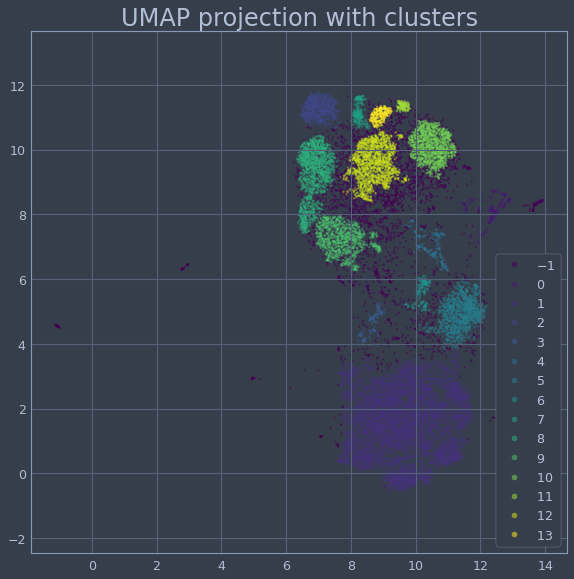

In [13]:
color_palette = sns.color_palette('Paired', 200)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in soft_clusters]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

print(validity)
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    three_embedding[:, 0],
    three_embedding[:, 1], 
#     three_embedding[:, 2],
    s=5, linewidth=0, 
    c=clusterer.labels_,
#     c="black",
    alpha=0.5)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection with clusters', fontsize=24)

# plt.scatter(three_embedding[:, 0],
#     three_embedding[:, 1], s=5, linewidth=0, c=cluster_member_colors, alpha=0.5)
# legend = plt.legend(*scatter.legend_elements(), loc="upper left")
# plt.add_artist(legend)

Text(0.5, 1.0, 'UMAP projection')

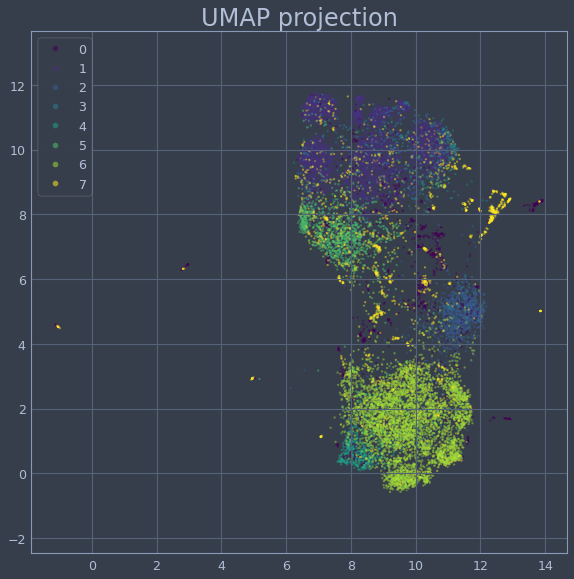

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    three_embedding[:, 0],
    three_embedding[:, 1], 
#     three_embedding[:, 2],
    s=5, linewidth=0, 
    c=three_depths_df.iloc[:,-1].values,
#     c="black",
    alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
ax.set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

# Four Strains

In [161]:
# rho = pd.read_csv('rho_matrix.tsv', sep='\t')
four_depths_df = pd.read_csv('four_test_depths.vcf', sep="\t")
# four_depths_clr = skbio.stats.composition.clr(four_depths)
four_depths_raw = four_depths_df.iloc[:,:-1].values
four_depths_clr = skbio.stats.composition.clr(four_depths_raw+1)# depths = scale(depths, axis=0, with_mean=True, with_std=True, copy=True)
four_depths = MinMaxScaler().fit_transform(four_depths_raw)

var_d = pd.read_csv('four_var_depths.vcf', sep="\t") + 1
ref_d = pd.read_csv('four_ref_depths.vcf', sep="\t") + 1
# depths_clr = skbio.stats.composition.clr(var_d)


In [162]:
four_depths_pca = PCA(n_components=2, svd_solver='full')
four_depths_pca.fit(four_depths_clr.T)
# projection = TSNE().fit_transform(depths)
set(four_depths_df.iloc[:,-1].values)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

Text(0.5, 1.0, 'PCA labelled by variant assignment')

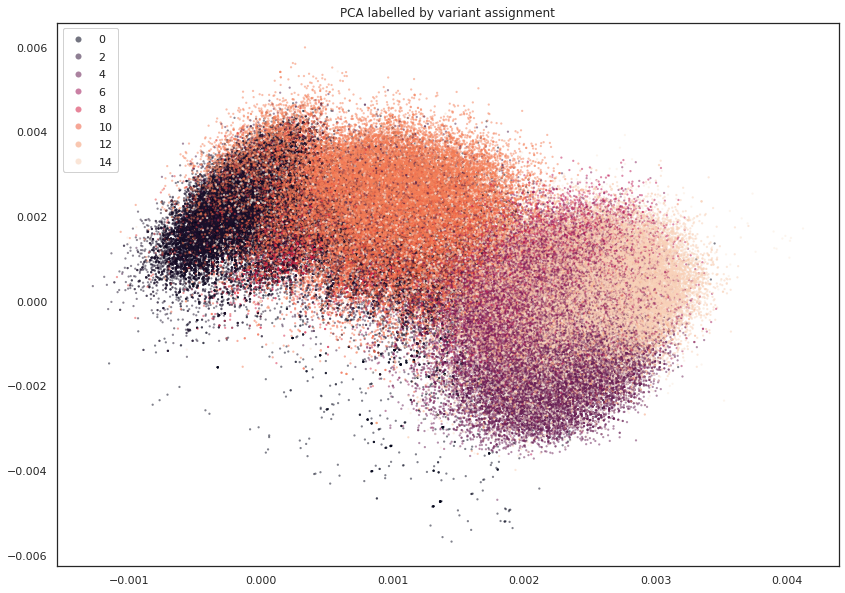

In [163]:
## Correctly labelled

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    *four_depths_pca.components_[0:2], 
#     two_embedding[:, 2],
    s=5, linewidth=0, c=four_depths_df.iloc[:,-1].values, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
plt.title("PCA labelled by variant assignment")

In [166]:
### UMAP
tic = time.clock()
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0,
#     spread=3,
    n_components=4,
    random_state=42
)
four_embedding = reducer.fit_transform(four_depths_clr)
four_embedding.shape
toc = time.clock()
print((toc - tic)/60)

317.0863370833333


Text(0.5, 1.0, 'UMAP projection')

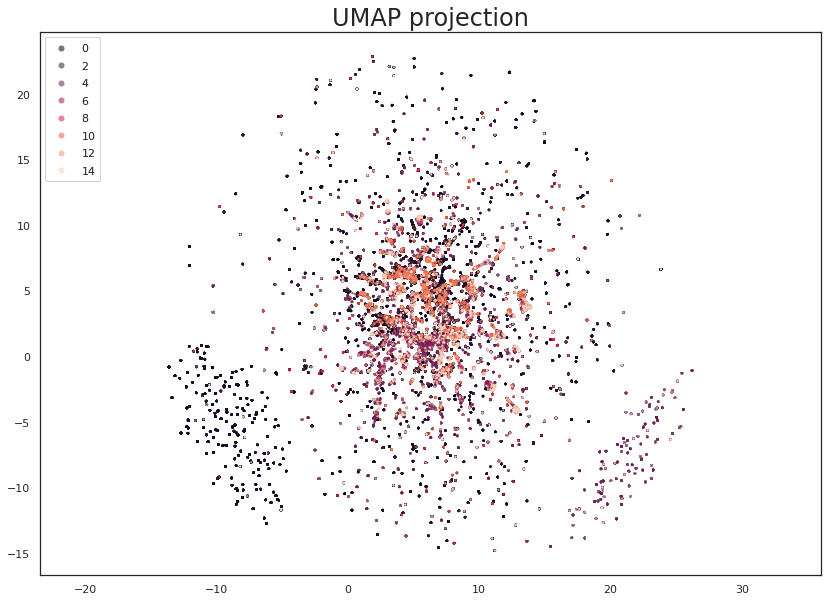

In [167]:
## Correctly labelled
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    four_embedding[:, 0],
    four_embedding[:, 1],
    s=2, alpha=0.5, c=four_depths_df.iloc[:,-1].values
)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [60]:
## UMAP Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(four_depths.shape[0]*0.05), min_samples=50, prediction_data=True, cluster_selection_method="eom")
clusterer.fit(four_embedding)

## PCA Clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=100, prediction_data=True, cluster_selection_method="eom")
# clusterer.fit(four_depths_pca.components_.T)

NameError: name 'four_depths' is not defined

In [1]:
labels = set(clusterer.labels_)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_clusters = [np.argmax(x) for x in soft_clusters]

# print(soft_clusters)
for label in labels: 
    print("%d found %d and soft labels %d" % (label, np.count_nonzero(clusterer.labels_ == label), np.count_nonzero(soft_clusters == label)))
    
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

NameError: name 'clusterer' is not defined

Text(0.5, 1.0, 'UMAP projection')

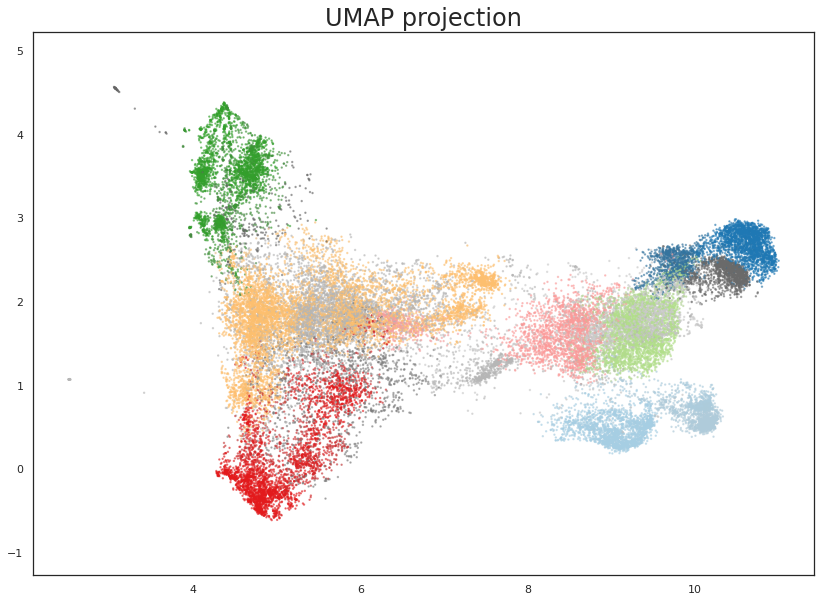

In [75]:
color_palette = sns.color_palette('Paired', 200)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in soft_clusters]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    four_embedding[:, 0],
    four_embedding[:, 1],
    s=2, alpha=0.5, c=cluster_member_colors)
# legend = ax.legend(*scatter.legend_elements(), loc="upper left")
# ax.add_artist(legend)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
# plt.title("PCA and HDBSCAN clustering", fontsize=24)
# plt.scatter(*four_depths_pca.components_[0:2], s=5, linewidth=0, c=cluster_member_colors, alpha=0.5)


Text(0.5, 0.92, 'UMAP projection')

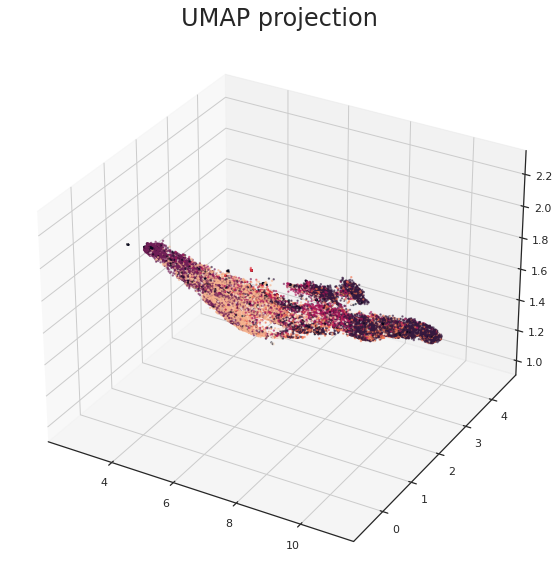

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    four_embedding[:, 0],
    four_embedding[:, 1],
    four_embedding[:, 2],
    s=2, alpha=0.5, c=four_depths_df.iloc[:,-1].values)
# legend = ax.legend(*scatter.legend_elements(), loc="upper left")
# ax.add_artist(legend)
plt.title('UMAP projection', fontsize=24)

# Five Strains

In [33]:
# rho = pd.read_csv('rho_matrix.tsv', sep='\t')
five_depths_df = pd.read_csv('five_test_depths.vcf', sep="\t")
# five_depths_clr = skbio.stats.composition.clr(five_depths)
five_depths_raw = five_depths_df.iloc[:,:-1].values
# five_depths_clr = skbio.stats.composition.clr(five_depths_raw+1) 
five_depths_clr = skbio.stats.composition.clr((five_depths_raw+1).T).T 

# depths = scale(depths, axis=0, with_mean=True, with_std=True, copy=True)
five_depths = MinMaxScaler().fit_transform(five_depths_raw)

var_d = pd.read_csv('five_var_depths.vcf', sep="\t") + 1
ref_d = pd.read_csv('five_ref_depths.vcf', sep="\t") + 1
# depths_clr = skbio.stats.composition.clr(var_d)

In [272]:
five_depths_df[five_depths_df['bin']==0]

,lorikeet-genome.sample10_R1.fq.gz,lorikeet-genome.sample1_R1.fq.gz,lorikeet-genome.sample2_R1.fq.gz,lorikeet-genome.sample3_R1.fq.gz,lorikeet-genome.sample4_R1.fq.gz,lorikeet-genome.sample5_R1.fq.gz,lorikeet-genome.sample6_R1.fq.gz,lorikeet-genome.sample7_R1.fq.gz,lorikeet-genome.sample8_R1.fq.gz,lorikeet-genome.sample9_R1.fq.gz,bin
1,8,0,7,0,2,107,0,3,8,11,0
2,2,0,1,0,8,54,4,2,9,8,0
99,2,0,1,2,0,26,1,0,7,0,0
129,1,0,1,1,2,26,1,2,11,0,0
151,1,0,1,2,1,19,1,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...
34228,25,0,4,2,12,222,6,11,20,14,0
34231,23,0,3,1,18,204,6,9,25,17,0
34235,18,0,8,1,15,228,11,6,18,13,0
34237,14,0,8,2,14,237,10,8,25,15,0


In [274]:
five_depths_pca = PCA(n_components=5, svd_solver='full')
five_depths_pca.fit(five_depths_raw.T)
# projection = TSNE().fit_transform(depths)
five_depths_df.values.shape

(35016, 11)

Text(0.5, 1.0, 'PCA labelled by variant assignment')

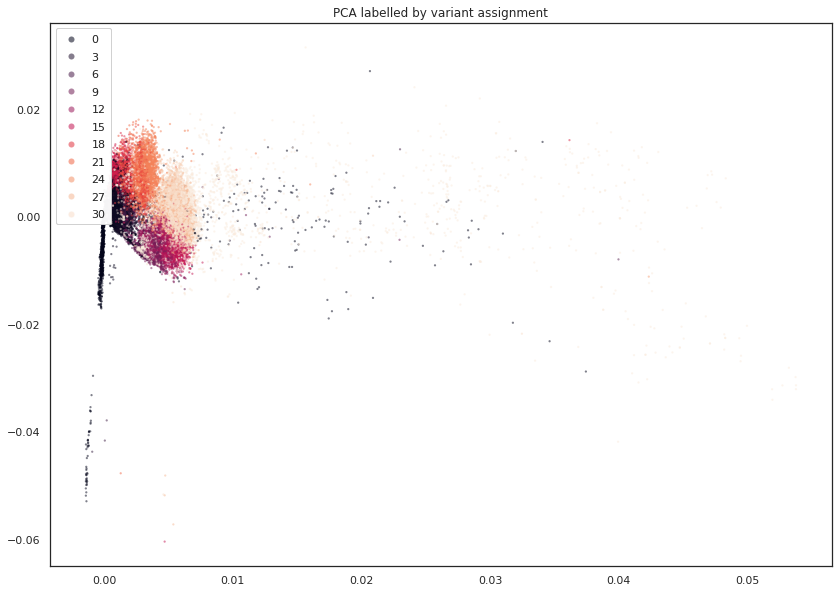

In [275]:
## Correctly labelled

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(
    *five_depths_pca.components_[0:2], 
#     five_embedding[:, 2],
    s=5, linewidth=0, c=five_depths_df.iloc[:,-1].values, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
plt.title("PCA labelled by variant assignment")

In [276]:
five_depths_clr.shape

(35016, 10)

In [85]:
### UMAP
tic = time.clock()
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0.1,
#     spread=3,
    n_components=2,
    random_state=42,
    metric=rho
)
five_embedding = reducer.fit_transform(five_depths_clr)
five_embedding.shape
toc = time.clock()
print((toc - tic)/60)

/home/n10853499/.conda/envs/r-3.6.3/lib/python3.6/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "


2.595221799999998


Text(0.5, 1.0, 'UMAP projection: Metric - Rho')

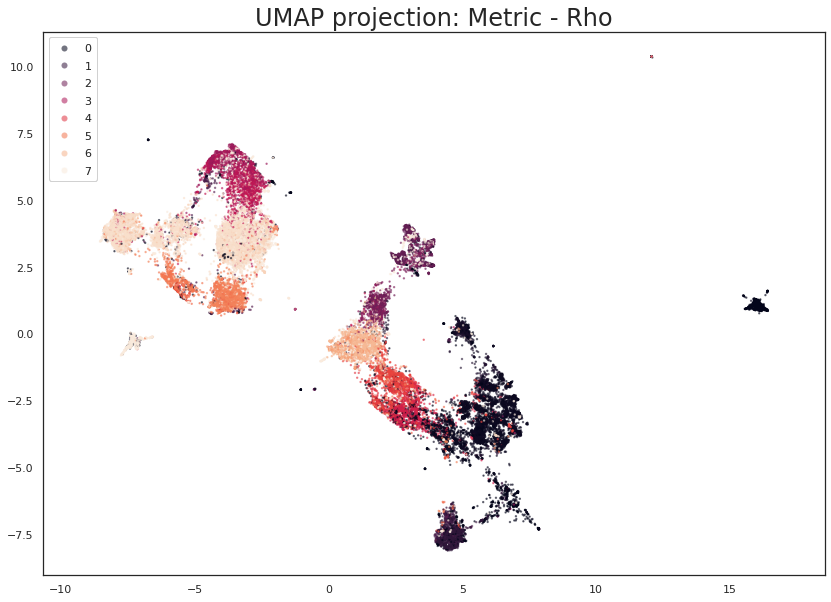

In [80]:
## Correctly labelled
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    five_embedding[:, 0],
    five_embedding[:, 1],
    s=2, alpha=0.5, c=five_depths_df.iloc[:,-1].values
)
legend = ax.legend(*scatter.legend_elements(), loc="upper left")
ax.add_artist(legend)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection: Metric - Rho', fontsize=24)

In [82]:
## UMAP Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(five_depths.shape[0]*0.01), min_samples=1, prediction_data=True, cluster_selection_method="eom")
clusterer.fit(five_embedding)




## PCA Clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, prediction_data=True, cluster_selection_method="eom")
# clusterer.fit(five_depths_pca.components_.T)

HDBSCAN(min_cluster_size=350, min_samples=1, prediction_data=True)

0 found 717 and soft labels 774
1 found 542 and soft labels 542
2 found 2028 and soft labels 1935
3 found 607 and soft labels 700
4 found 1995 and soft labels 2008
5 found 759 and soft labels 776
6 found 13086 and soft labels 13188
7 found 2347 and soft labels 2346
8 found 902 and soft labels 894
9 found 1992 and soft labels 2103
10 found 725 and soft labels 936
11 found 614 and soft labels 705
12 found 4347 and soft labels 4532
13 found 740 and soft labels 1198
14 found 509 and soft labels 1033
15 found 1308 and soft labels 1346
-1 found 1798 and soft labels 0


<AxesSubplot:ylabel='$\\lambda$ value'>

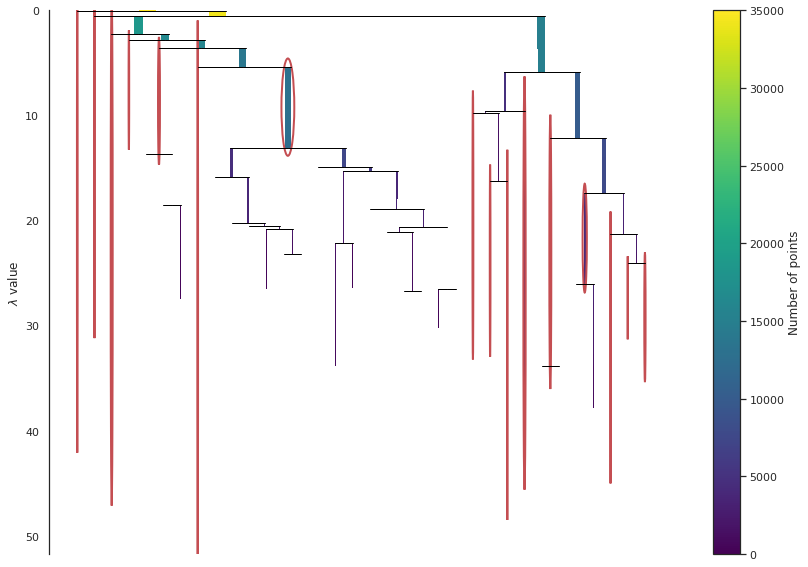

In [83]:
labels = set(clusterer.labels_)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_clusters = [np.argmax(x) for x in soft_clusters]

# print(soft_clusters)
for label in labels: 
    print("%d found %d and soft labels %d" % (label, np.count_nonzero(clusterer.labels_ == label), np.count_nonzero(soft_clusters == label)))
    
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

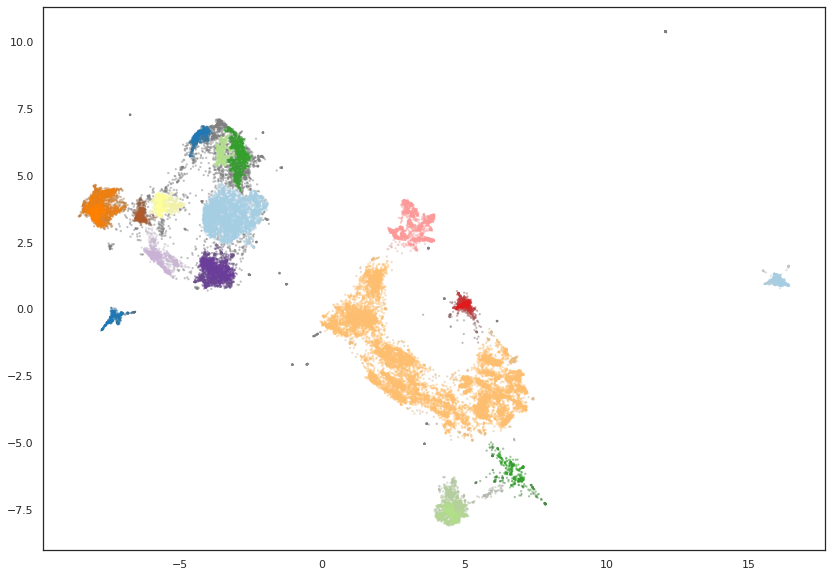

In [84]:
color_palette = sns.color_palette('Paired', 200)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(five_embedding[:, 0],
    five_embedding[:, 1], s=5, linewidth=0, c=cluster_member_colors, alpha=0.5)

IndexError: index 2 is out of bounds for axis 1 with size 2

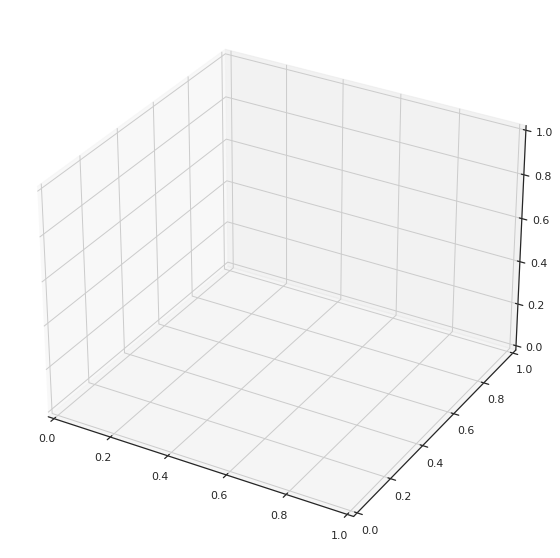

In [282]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    five_embedding[:, 0],
    five_embedding[:, 1],
    five_embedding[:, 2],
    s=2, alpha=0.5, c=five_depths_df.iloc[:,-1].values)
# legend = ax.legend(*scatter.legend_elements(), loc="upper left")
# ax.add_artist(legend)
plt.title('UMAP projection', fontsize=24)

# Test Code

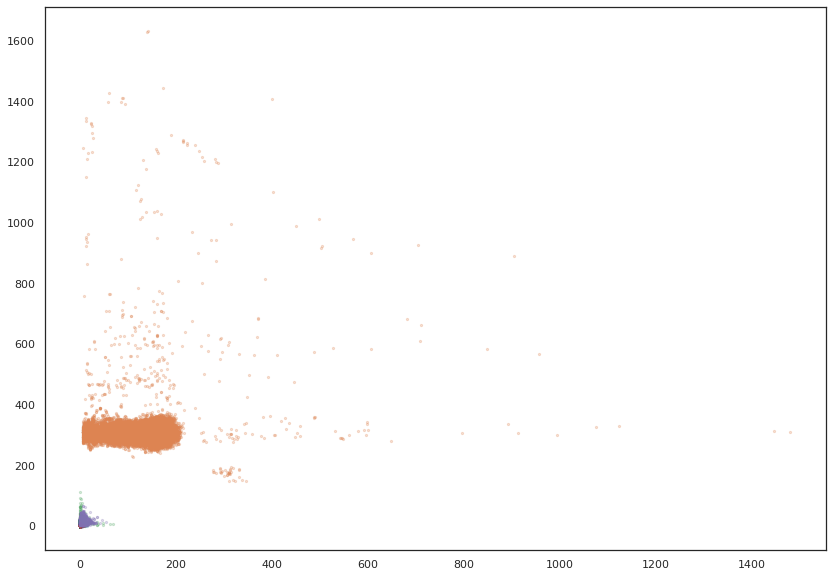

In [721]:
plt.scatter(var_d.values[:,0], ref_d.values[:,0], s=5, alpha=0.25)
plt.scatter(var_d.values[:,1], ref_d.values[:,1], s=5, alpha=0.25)
plt.scatter(var_d.values[:,2], ref_d.values[:,2], s=5, alpha=0.25)
plt.scatter(var_d.values[:,3], ref_d.values[:,3], s=5, alpha=0.25)
plt.scatter(var_d.values[:,4], ref_d.values[:,4], s=5, alpha=0.25)

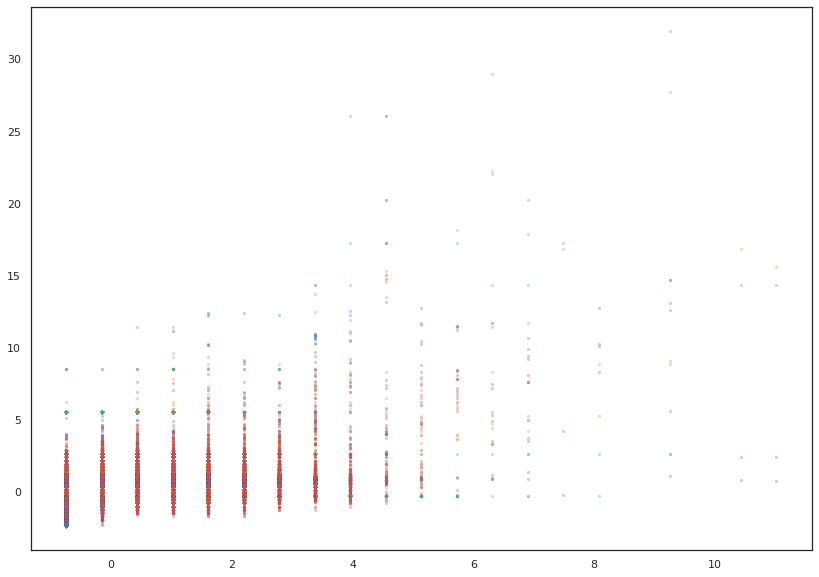

In [722]:
plt.scatter(depths[:,0], depths[:,1], s=5, alpha=0.25)
plt.scatter(depths[:,0], depths[:,2], s=5, alpha=0.25)
plt.scatter(depths[:,0], depths[:,3], s=5, alpha=0.25)
plt.scatter(depths[:,0], depths[:,4], s=5, alpha=0.25)
# plt.scatter(var_d.values[:,4], ref_d.values[:,4], s=5, alpha=0.25)

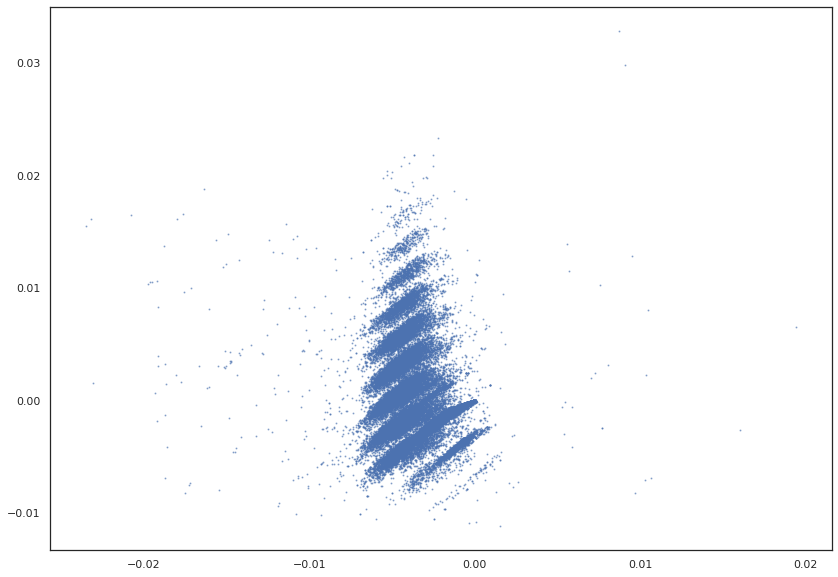

In [782]:
depths_pca = PCA(n_components=5, svd_solver='full')
depths_pca.fit(depths.T)
# projection = TSNE().fit_transform(depths)
plt.scatter(*depths_pca.components_[0:2], s=1, alpha=0.5)
# depths_pca.components_

In [788]:
### UMAP
tic = time.clock()
reducer = umap.UMAP(
    n_neighbors=100,
    min_dist=0,
#     spread=3,
    n_components=2,
    random_state=42
)
embedding = reducer.fit_transform(depths_raw)
embedding.shape
toc = time.clock()
print((toc - tic)/60)

11.671640483333613


Text(0.5, 1.0, 'UMAP projection')

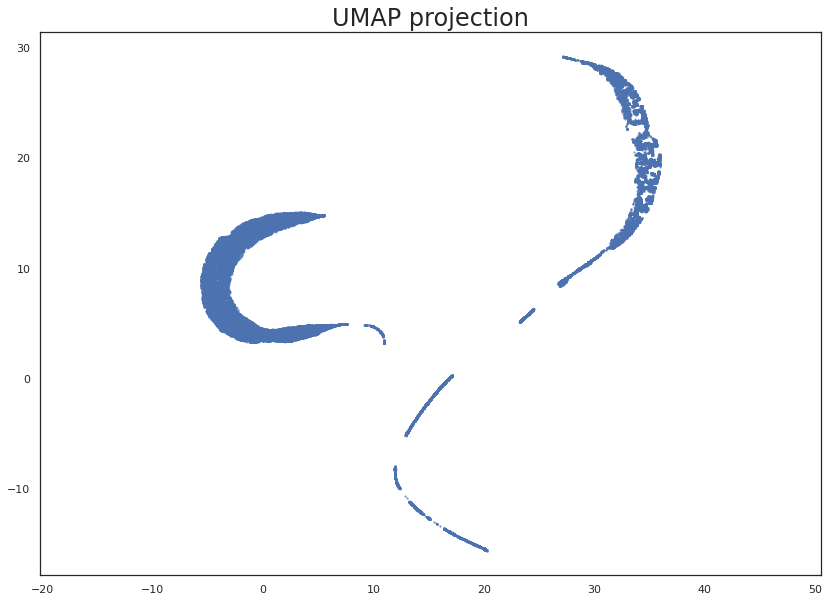

In [789]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=2, alpha=0.5
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [785]:
## UMAP Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=100, prediction_data=True, cluster_selection_method="eom")
clusterer.fit(embedding)

## PCA Clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=100, prediction_data=True, cluster_selection_method="eom")
# clusterer.fit(depths_pca.components_.T)

HDBSCAN(min_cluster_size=500, min_samples=100, prediction_data=True)

In [349]:
depths_pca.components_

array([[-2.71726939e-02, -1.38528375e-02, -1.48496067e-02, ...,
        -3.19160765e-02, -2.06981022e-02, -3.78424351e-02],
       [-8.10047490e-03, -1.17945163e-02, -1.79601658e-02, ...,
         2.62731727e-02, -1.87333164e-05,  1.41729584e-02],
       [ 3.22900493e-02,  1.00958589e-03,  2.53745216e-03, ...,
        -6.91373338e-03,  1.13142451e-02, -2.89642294e-02]])

<AxesSubplot:ylabel='$\\lambda$ value'>

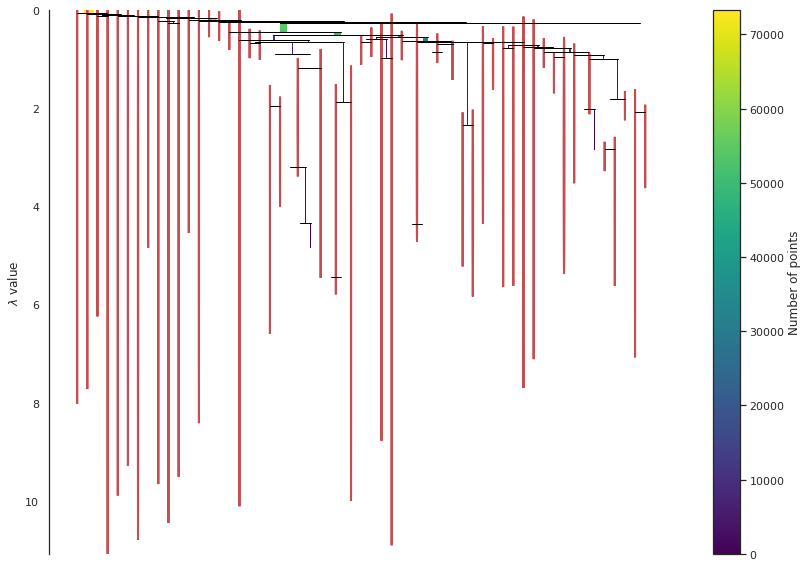

In [786]:
# rho.iloc[1]
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

In [778]:
labels = set(clusterer.labels_)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
soft_clusters = [np.argmax(x) for x in soft_clusters]

# print(soft_clusters)
for label in labels: 
    print("%d found %d and soft labels %d" % (label, np.count_nonzero(clusterer.labels_ == label), np.count_nonzero(soft_clusters == label)))

0 found 29750 and soft labels 29750
1 found 36749 and soft labels 36749
2 found 1044 and soft labels 1044
3 found 2619 and soft labels 2619
4 found 953 and soft labels 953
5 found 636 and soft labels 636
6 found 1499 and soft labels 1503
-1 found 4 and soft labels 0


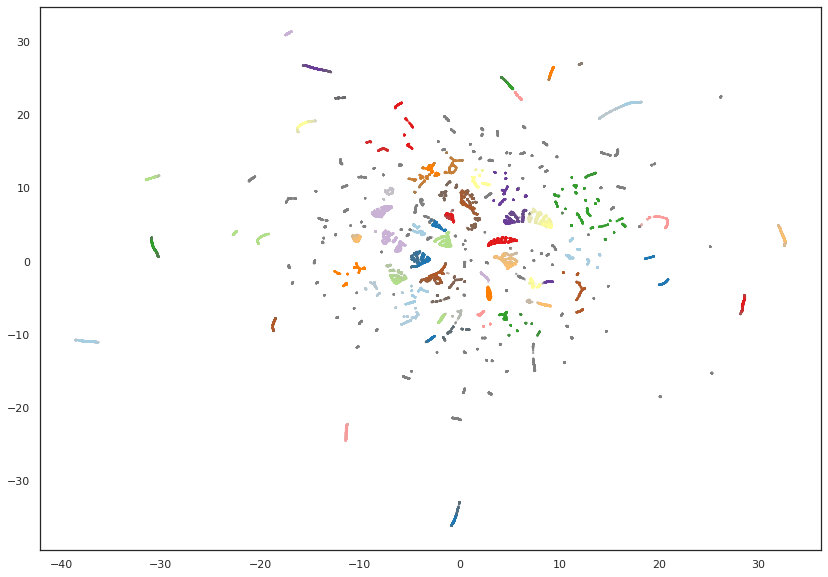

In [787]:
color_palette = sns.color_palette('Paired', 200)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(embedding[:, 0],
    embedding[:, 1], s=5, linewidth=0, c=cluster_member_colors, alpha=0.5)

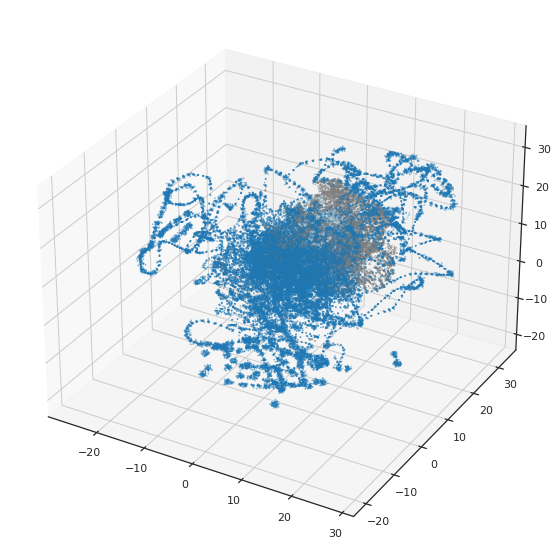

In [767]:
color_palette = sns.color_palette('Paired', 200)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=3, linewidth=0, c=cluster_member_colors, alpha=0.5)
# ax.scatter(*depths_pca.components_[0:4, outliers], s=1, linewidth=0, c='pink', alpha=0.25)
plt.show()

/home/n10853499/.conda/envs/r-3.6.3/lib/python3.6/site-packages/mpl_toolkits/mplot3d/art3d.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/n10853499/.conda/envs/r-3.6.3/lib/python3.6/site-packages/mpl_toolkits/mplot3d/art3d.py:765: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


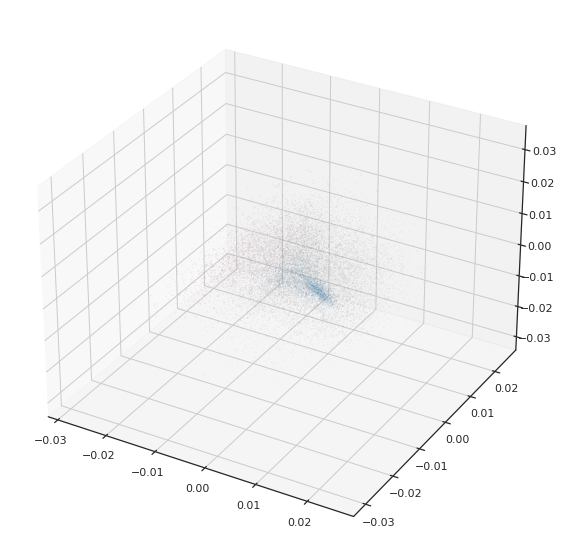

In [675]:
color_palette = sns.color_palette('Paired', 30)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*depths_pca.components_[0:4], s=1, linewidth=0, c=cluster_member_colors, alpha=0.1)
ax.scatter(*depths_pca.components_[0:4, outliers], s=1, linewidth=0, c='pink', alpha=0.25)
plt.show()

/home/n10853499/.conda/envs/r-3.6.3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/n10853499/.conda/envs/r-3.6.3/lib/python3.6/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

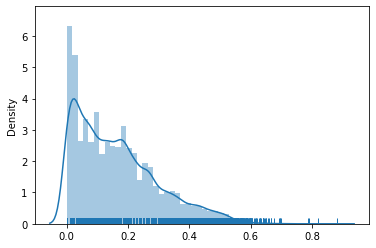

In [435]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

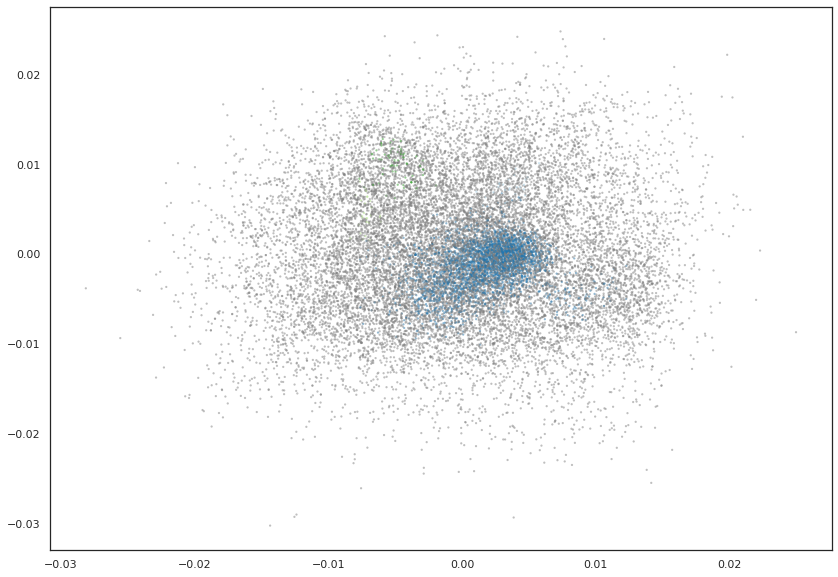

In [676]:
color_palette = sns.color_palette('Paired', 30)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*depths_pca.components_[0:2], s=5, linewidth=0, c=cluster_member_colors, alpha=0.5)
# plt.scatter(*depths_pca.components_[0:2, outliers], s=5, linewidth=0, c='red', alpha=0.25)

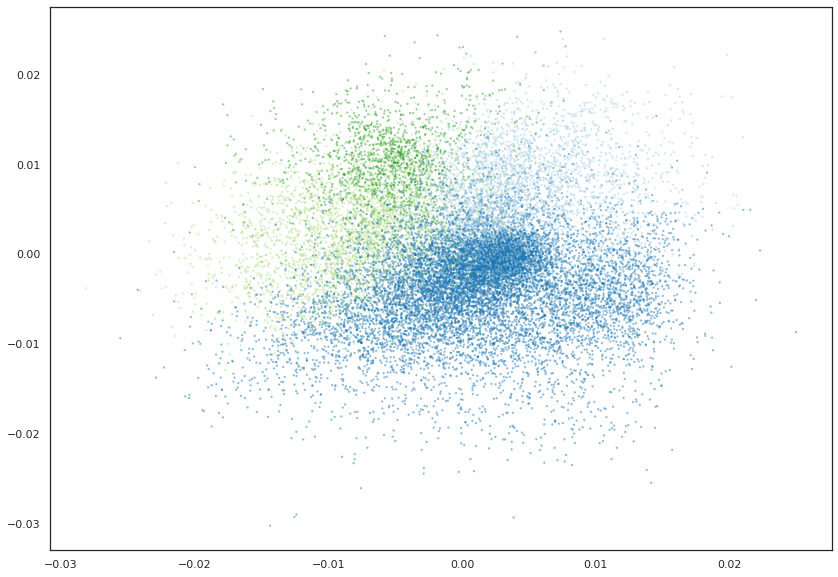

In [677]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 30)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*depths_pca.components_[0:2], s=5, linewidth=0, c=cluster_colors, alpha=0.5)

# Functions

In [6]:
def mp_cluster(df, n, gamma, ms, method='eom'):
    clust_alg = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=True, 
                                    leaf_size=40,
                                    cluster_selection_method=method,
                                    metric='euclidean', 
                                    min_cluster_size=int(gamma * np.sqrt(n)), 
                                    min_samples=ms,
                                    allow_single_cluster=False,
                                    core_dist_n_jobs=20).fit(df)

    min_cluster_size = clust_alg.min_cluster_size 
    min_samples = clust_alg.min_samples
    validity_score = clust_alg.relative_validity_
    n_clusters = np.max(clust_alg.labels_)
    
    return (min_cluster_size, min_samples, validity_score, n_clusters)


def hyperparameter_selection(df, cores=10, method='eom'):
    import warnings
    import multiprocessing as mp
    
    pool = mp.Pool(cores)
    warnings.filterwarnings('ignore')
    results=[]
    n = df.shape[0]
    for gamma in range (1, int(np.log(n))):
        mp_results = [pool.apply_async(mp_cluster, args=(df, n, gamma, ms, method)) for ms in range(1, int(2*np.log(n)))]
        for result in mp_results:
            result = result.get()
            results.append(result)
            if result[2] >= .5:
                print (f'min_cluster_size = {result[0]},  min_samples = {results[1]}, validity_score = {result[2]} n_clusters = {result[3]}')
            
#         for ms in range(1, int(2 * np.log(n))):
#             clust_alg = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
#                                     approx_min_span_tree=True,
#                                     gen_min_span_tree=True, 
#                                     leaf_size=40,
#                                     cluster_selection_method=method,
#                                     metric='euclidean', 
#                                     min_cluster_size=int(gamma * np.sqrt(n)), 
#                                     min_samples=ms,
#                                     allow_single_cluster=False,
#                                     core_dist_n_jobs=20).fit(df)

#             min_cluster_size = clust_alg.min_cluster_size 
#             min_samples = clust_alg.min_samples
#             validity_score = clust_alg.relative_validity_
#             n_clusters = np.max(clust_alg.labels_) 
#             results.append((min_cluster_size, min_samples, validity_score, n_clusters))
#             if validity_score >= .5:
#                 print (f'min_cluster_size = {min_cluster_size},  min_samples = {min_samples}, validity_score = {validity_score} n_clusters = {n_clusters}')
    
    return results


def best_validity(source):
    cols = ['min_cluster_size', 'min_samples', 'validity_score', 'n_clusters']
    df =  pd.DataFrame(source, columns = cols)
    best_validity = df.loc[df['validity_score'].idxmax()]
    return best_validity

def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, unicode):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, unicode):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes_iter(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges_iter(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes_iter(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges_iter(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

# DEBUG

In [4]:
#Setup
import multiprocessing as mp
from Bio import SeqIO
from itertools import product
import pandas as pd
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
import skbio.stats.composition
import threadpoolctl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import umap
import time
import numba
assembly = SeqIO.to_dict(SeqIO.parse("/lustre/scratch/microbiome/n10853499/99-STRONG_sim/Synth_G45_S15D/assembly/scaffolds.fasta", "fasta"))

coverage_table = pd.read_csv("/lustre/scratch/microbiome/n10853499/99-STRONG_sim/Synth_G45_S15D/binning/data_rosella/coverm.cov", sep='\t')
large_contigs = coverage_table[coverage_table["contigLen"] >= 1000]
tnfs = pd.DataFrame(columns=[''.join(p)  for p in product('ATCG', repeat=4)])

pool = mp.Pool(128)

In [5]:
# Functions
def spawn_count(idx, seq):
    tetras = {''.join(p): 0 for p in product('ATCG', repeat=4)}
    forward = str(seq).upper()
    reverse = str(seq.reverse_complement()).upper()
    for s in [forward, reverse]:
        for i in range(len(s[:-4])):
            tetra = s[i:i + 4]
            if all(i in tetra for i in ("A", "T", "C", "G")):
                tetras[tetra] += 1
    return pd.Series(tetras, name=idx)

# def spawn_count(idx, seq):

#     forward = str(seq).upper()
#     reverse = str(seq.reverse_complement()).upper()
#     for s in [forward,
#               reverse]:
#         pool.apply_async(merge_count, args=(s, idx), callback=collect_count)

        
def merge_count(s, idx):
    # for tetranucleotide counts, we loop over the sequence and rc
    tetras = {''.join(p): 0 for p in product('ATCG', repeat=4)}
    for i in range(len(s[:-4])):
        tetra = s[i:i + 4]
        if all(i in tetra for i in ("A", "T", "C", "G")):
            tetras[str(tetra)] += 1
    return (tetras, idx)

def collect_count(tnfs, result):
    for (tnf, count) in result[0].items():
        tnfs[tnf][result[1]] += count

#         pool.apply_async(add_count, args=(tnf, result[1], count))

# def add_count(tnf, counts, results):
    
#     for result in results:
#         tnf_counts = result[0]
        
    
#     tnfs[tnf][idx] += count
    
    
# def spawn_count(idx, seq):
# #     seq = assembly[contig].seq
#     tetras = {''.join(p): 0 for p in product('ATCG', repeat=4)}
#     forward = str(seq).upper()
#     reverse = str(seq.reverse_complement()).upper()
#     for s in [forward,
#                       reverse]:
#             # for tetranucleotide counts, we loop over the sequence and rc
#         for i in range(len(s[:-4])):
#             tetra = s[i:i + 4]
#             if "N" not in tetra:
# #             result = pool.apply_async(tnf_count, args=(i, s, idx, tnfs)).get()
#                 tetras[str(tetra)] += 1
#     return (tetras, idx)
# #     for (tnf, count) in tetras.items():
# #         tnfs[tnf][idx] = count

# def merge_count(s, idx, contig):
#     for i in range(len(s[:-4])):
#             tetra = s[i:i + 4]
#             if "N" not in tetra:
# #             result = pool.apply_async(tnf_count, args=(i, s, idx, tnfs)).get()
#                 tetras[str(tetra)] += 1

# def tnf_count(i, s, idx):
# #     for i in range(len(s[:-4])):
#     tetra = s[i:i + 4]
# #     tnfs[str(tetra)][idx] += 1

# #             result = pool.apply_async(tnf_count, args=(s, i, idx))
#     return (tetra, idx)

# def collect_count(result):
# #     global tnfs
#     for (tnf, count) in result[0].items():
#         tnfs[tnf][result[1]] = count
        
        
# def slow_tnf(idx, contig, tnfs):
#     seq = assembly[contig].seq
#     for s in [str(seq).upper(),
#               str(seq.reverse_complement()).upper()]:
#         # for tetranucleotide counts, we loop over the sequence and rc
#         for i in range(len(s[:-4])):
#             tetra = s[i:i + 4]
#             try:
#                 tnfs[str(tetra)][idx] += 1
#             except IndexError:
#                 tnfs[str(tetra)] = [0] * large_contigs.iloc[:, 0].values.shape[0]
#                 tnfs[str(tetra)][idx] += 1

In [13]:

pool = mp.Pool(128)
# for (idx, contig) in enumerate(large_contigs.iloc[:, 0]):
#     seq = assembly[contig].seq
#     pool.apply_async(spawn_count, args=(idx, assembly[contig].seq), callback=collect_count)
    
results = pool.starmap_async(spawn_count, [(idx, assembly[contig].seq) for (idx, contig) in enumerate(large_contigs.iloc[:, 0])]).get()

pool.close()
pool.join()

In [19]:
sum(results[0])

366290

In [15]:
tnfs = pd.DataFrame(results)

In [11]:
pd.Series({'A':10,'B':20,'C':30,'D':40},name=3)

A    10
B    20
C    30
D    40
Name: 3, dtype: int64

In [16]:
tnfs_df = pd.DataFrame.from_dict(tnfs)
tnfs_norm = tnfs_df.div(tnfs_df.sum(axis=1), axis=0)

In [21]:
tnfs_df.sum(axis=1)

0        366290
1        173972
2        168068
3        152042
4        153926
          ...  
25551       114
25552       194
25553       142
25554       144
25555       186
Length: 25556, dtype: int64

In [22]:
from Bio.Seq import Seq
seq = Seq("ATCGGCTAATCG")
tnf_dict = {}
for s in [str(seq).upper(),
          str(seq.reverse_complement()).upper()]:
    # For di, tri and tetranucleotide counts, we loop over the
    # sequence and its reverse complement, until we're near the end:
    for i in range(len(s[:-4])):
        tetra = s[i:i + 4]
        try:
            tnf_dict[str(tetra)][0] += 1
        except:
            tnf_dict[str(tetra)] = [0] * 1
            tnf_dict[str(tetra)][0] += 1

# for (tnf, vector) in tnf_dict.items():
#     vector_sum = sum(vector)
#     freqs = [x/vector_sum for x in vector]
#     self.depths[tnf] = freqs

for tnf, counts in tnf_dict.items():
#         pool.apply_async(tnf_count, args=(idx, contig, tnf, counts))
    forward = str(seq).upper()
    reverse = str(seq.reverse_complement()).upper()
#     for frame in [0, 1, 2]:
    for s in [forward,
        reverse]:
        for i in range(len(s[:-4])):
            tetra = s[i:i + 4]
            if tetra == tnf:
                counts[0] += 1

ATCG ATCG
TCGG ATCG
CGGC ATCG
GGCT ATCG
GCTA ATCG
CTAA ATCG
TAAT ATCG
AATC ATCG
CGAT ATCG
GATT ATCG
ATTA ATCG
TTAG ATCG
TAGC ATCG
AGCC ATCG
GCCG ATCG
CCGA ATCG
ATCG TCGG
TCGG TCGG
CGGC TCGG
GGCT TCGG
GCTA TCGG
CTAA TCGG
TAAT TCGG
AATC TCGG
CGAT TCGG
GATT TCGG
ATTA TCGG
TTAG TCGG
TAGC TCGG
AGCC TCGG
GCCG TCGG
CCGA TCGG
ATCG CGGC
TCGG CGGC
CGGC CGGC
GGCT CGGC
GCTA CGGC
CTAA CGGC
TAAT CGGC
AATC CGGC
CGAT CGGC
GATT CGGC
ATTA CGGC
TTAG CGGC
TAGC CGGC
AGCC CGGC
GCCG CGGC
CCGA CGGC
ATCG GGCT
TCGG GGCT
CGGC GGCT
GGCT GGCT
GCTA GGCT
CTAA GGCT
TAAT GGCT
AATC GGCT
CGAT GGCT
GATT GGCT
ATTA GGCT
TTAG GGCT
TAGC GGCT
AGCC GGCT
GCCG GGCT
CCGA GGCT
ATCG GCTA
TCGG GCTA
CGGC GCTA
GGCT GCTA
GCTA GCTA
CTAA GCTA
TAAT GCTA
AATC GCTA
CGAT GCTA
GATT GCTA
ATTA GCTA
TTAG GCTA
TAGC GCTA
AGCC GCTA
GCCG GCTA
CCGA GCTA
ATCG CTAA
TCGG CTAA
CGGC CTAA
GGCT CTAA
GCTA CTAA
CTAA CTAA
TAAT CTAA
AATC CTAA
CGAT CTAA
GATT CTAA
ATTA CTAA
TTAG CTAA
TAGC CTAA
AGCC CTAA
GCCG CTAA
CCGA CTAA
ATCG TAAT
TCGG TAAT
CGGC TAAT
GGCT TAAT


In [23]:
tnf_dict

{'ATCG': [2],
 'TCGG': [2],
 'CGGC': [2],
 'GGCT': [2],
 'GCTA': [2],
 'CTAA': [2],
 'TAAT': [2],
 'AATC': [2],
 'CGAT': [2],
 'GATT': [2],
 'ATTA': [2],
 'TTAG': [2],
 'TAGC': [2],
 'AGCC': [2],
 'GCCG': [2],
 'CCGA': [2]}